In [20]:
from HeaderP import *
def monoage_line_range(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[], plotlegend=True, pltfig=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    if pltfig:
        plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            slopes[i] = np.nan
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            slopes[i] = np.nan
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] =np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
        #fehscatter[i] = ave_inf(((agebin[i]+agebin[i+1])/2))-(np.percentile(feh_sing[m2],5))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if pltfig:
            plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if pltfig:
        if plotlegend:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
        plt.xlabel('R [kpc]')
        plt.ylabel('[Fe/H]')
        plt.xlim(xlims)
        plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter



def monoage_line_range_mc(feh,r,age,feh_err, r_err, age_err,
                          agebin=np.linspace(0,14,8),xlims=[6,12],
                          ylims=[-1.5,0.5],feherr=[], mcmc=100):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    fehscatter_err = np.zeros(len(agebin)-1)
    
    fehscatterall = np.zeros((mcmc,len(agebin)-1))*np.nan
  
    for j in trange(mcmc):
        age_new = np.array([np.random.normal(age[k], age_err[k]) for k in range(len(age))], dtype=float)
        r_new = np.array([np.random.normal(r[k], r_err[k]) for k in range(len(r))], dtype=float)
        feh_new = np.array([np.random.normal(feh[k], feh_err[k]) for k in range(len(feh))], dtype=float)

        
        for i in range(len(agebin)-1):
            m = (age_new>agebin[i])&(age_new<agebin[i+1])
            if sum(m)==0:
                fehscatterall[j,i] = np.nan
                continue
            r_sing, feh_sing = zip(*sorted(zip(r_new[m], feh_new[m])))
            r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)

            m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
            if sum(m2)==0:
                fehscatterall[j,i] = np.nan
                continue
            fehscatterall[j,i] =np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
    
    fehscatter = [np.median(fehscatterall[:,k]) for k in range(len(agebin)-1)]
    fehscatter_err = [np.std(fehscatterall[:,k]) for k in range(len(agebin)-1)]
    
    return (agebin[:-1]+agebin[1:])/2, fehscatter, fehscatter_err



def hilow_disk(feh, alpha):
    hi_low = np.zeros(len(feh))
    
    m = feh<-0.5
    hi_low[m] = alpha[m]>0.15
    
    p = fitpoints([-0.5,0.5], [0.15,0])
    hi_low[~m] = alpha[~m]>p(feh[~m])
    
    return hi_low


def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                print('not enough stars')
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print('not enough stars')
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)
                    #print(scatters[i,j])
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),
                feherr=[],xlims=[0,25],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    

    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()

    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in range(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<50:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
  

In [24]:
from astropy.table import Table
sub = Table.read('subgiant_fullparam_update.fits', format='fits')
sub = sub.to_pandas()
sub_rbir = pd.read_csv('RbirLAMOST.csv')
sub_rbir.columns

sub_rbir = sub_rbir.rename(columns={'          rb': 'Rb', 
                                    '          rb_err': 'Rb_err',
                                   '       specid':'specid'})
sub['SPECID'] = [str(i.decode(encoding="utf-8").split()[0]) for i in sub['SPECID']]
sub_rbir['specid'] = [str(i.split()[0]) for i in sub_rbir['specid']]

sub_rbir = pd.merge(sub, 
               sub_rbir[['specid', 'Rb', 'Rb_err']], 
               left_on='SPECID', right_on='specid', how='inner')
print(len(sub_rbir), len(sub))

200674 247104


In [22]:
"""xrange = [8.5,9.5]
agebincalc = np.linspace(0,16,17)
zsel_scale = 2500
Rsel_scale = 2500 
sub_rbir = sub_rbir.loc[abs(sub_rbir['ECC'])<0.5].reset_index(drop=True)
sub = sub.loc[abs(sub['ECC'])<0.5].reset_index(drop=True)

#sub_check = pd.read_csv('Xiang_fitline.csv')
sub = Table.read('subgiant_fullparam_update.fits', format='fits')
sub = sub.to_pandas()
sub['hi_low'] = hilow_disk(sub['FEH'].values, sub['ALPHA_FE'].values)


sub_check = sub.loc[abs(sub['Z'])<0.5]
print(np.diff(agebincalc)[0])
sub_check = sub_check.loc[sub_check['AGE_ERR']<np.diff(agebincalc)[0]]
sub_check = sub_check.loc[abs(sub_check['ECC'])<0.5]
sub_check = sub_check.loc[sub_check['FEH_ERR']<0.05].reset_index(drop=True)
#sub_check = sub_check.loc[sub_check['AGE_ERR']<0.5].reset_index(drop=True)

print(len(sub_check))
m = (sub_check['hi_low']==1)

sub_check['R_err'] = (sub_check['PARALLAX'])**-2*(sub_check['PARALLAX_ERROR'])
ages, fehscatter_mcmc_high, fehscatter_mcmc_err_high = monoage_line_range_mc(sub_check['FEH'].values[m], 
                                        sub_check['R_GUIDING'].values[m], 
                                        sub_check['AGE'].values[m],
                                        sub_check['FEH_ERR'].values[m], 
                                        sub_check['R_err'].values[m], 
                                        sub_check['AGE_ERR'].values[m],
                                        agebin=agebincalc,
                                        xlims=[0,15],
                                       feherr=sub_check['FEH_ERR'].values[m],
                                                                  mcmc=100)

ages, fehscatter_mcmc_low, fehscatter_mcmc_err_low = monoage_line_range_mc(sub_check['FEH'].values[~m], 
                                        sub_check['R_GUIDING'].values[~m], 
                                        sub_check['AGE'].values[~m],
                                        sub_check['FEH_ERR'].values[~m], 
                                        sub_check['R_err'].values[~m], 
                                        sub_check['AGE_ERR'].values[~m],
                                        agebin=agebincalc,
                                        xlims=[0,15],
                                       feherr=sub_check['FEH_ERR'].values[~m],
                                                                  mcmc=100)


a,b,c = monoage_line(sub_check['FEH'].values[m], 
                                        sub_check['R_GUIDING'].values[m], 
                                        sub_check['AGE'].values[m],
                                        agebin=agebincalc,
                                        xlims=[0,15])

a,b,c = monoage_line(sub_check['FEH'].values[~m], 
                                        sub_check['R_GUIDING'].values[~m], 
                                        sub_check['AGE'].values[~m],
                                        agebin=agebincalc,
                                        xlims=[0,15])

"""

"xrange = [8.5,9.5]\nagebincalc = np.linspace(0,16,17)\nzsel_scale = 2500\nRsel_scale = 2500 \nsub_rbir = sub_rbir.loc[abs(sub_rbir['ECC'])<0.5].reset_index(drop=True)\nsub = sub.loc[abs(sub['ECC'])<0.5].reset_index(drop=True)\n\n#sub_check = pd.read_csv('Xiang_fitline.csv')\nsub = Table.read('subgiant_fullparam_update.fits', format='fits')\nsub = sub.to_pandas()\nsub['hi_low'] = hilow_disk(sub['FEH'].values, sub['ALPHA_FE'].values)\n\n\nsub_check = sub.loc[abs(sub['Z'])<0.5]\nprint(np.diff(agebincalc)[0])\nsub_check = sub_check.loc[sub_check['AGE_ERR']<np.diff(agebincalc)[0]]\nsub_check = sub_check.loc[abs(sub_check['ECC'])<0.5]\nsub_check = sub_check.loc[sub_check['FEH_ERR']<0.05].reset_index(drop=True)\n#sub_check = sub_check.loc[sub_check['AGE_ERR']<0.5].reset_index(drop=True)\n\nprint(len(sub_check))\nm = (sub_check['hi_low']==1)\n\nsub_check['R_err'] = (sub_check['PARALLAX'])**-2*(sub_check['PARALLAX_ERROR'])\nages, fehscatter_mcmc_high, fehscatter_mcmc_err_high = monoage_line_ra

In [23]:
#plt.errorbar(ages, fehscatter_mcmc_high, yerr=fehscatter_mcmc_err_high)
#plt.errorbar(ages, fehscatter_mcmc_low, yerr=fehscatter_mcmc_err_low)




In [29]:
def monoage_line_range(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[], plotlegend=True, pltfig=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    if pltfig:
        plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            slopes[i] = np.nan
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            slopes[i] = np.nan
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] =np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
        #fehscatter[i] = ave_inf(((agebin[i]+agebin[i+1])/2))-(np.percentile(feh_sing[m2],5))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if pltfig:
            plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if pltfig:
        if plotlegend:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
        plt.xlabel('R [kpc]')
        plt.ylabel('[Fe/H]')
        plt.xlim(xlims)
        plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter



def monoage_line_range_mc(feh,r,age,feh_err, r_err, age_err,
                          agebin=np.linspace(0,14,8),xlims=[6,12],
                          ylims=[-1.5,0.5],feherr=[], mcmc=100):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    fehscatter_err = np.zeros(len(agebin)-1)
    
    fehscatterall = np.zeros((mcmc,len(agebin)-1))*np.nan
  
    for j in trange(mcmc):
        age_new = np.array([np.random.normal(age[k], age_err[k]) for k in range(len(age))], dtype=float)
        r_new = np.array([np.random.normal(r[k], r_err[k]) for k in range(len(r))], dtype=float)
        feh_new = np.array([np.random.normal(feh[k], feh_err[k]) for k in range(len(feh))], dtype=float)

        
        for i in range(len(agebin)-1):
            m = (age_new>agebin[i])&(age_new<agebin[i+1])
            if sum(m)==0:
                fehscatterall[j,i] = np.nan
                continue
            r_sing, feh_sing = zip(*sorted(zip(r_new[m], feh_new[m])))
            r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)

            m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
            if sum(m2)==0:
                fehscatterall[j,i] = np.nan
                continue
            fehscatterall[j,i] =np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
    
    fehscatter = [np.median(fehscatterall[:,k]) for k in range(len(agebin)-1)]
    fehscatter_err = [np.std(fehscatterall[:,k]) for k in range(len(agebin)-1)]
    
    return (agebin[:-1]+agebin[1:])/2, fehscatter, fehscatter_err



In [601]:
xrange = [8.5,9.5]
agebincalc = np.linspace(0,16,17)
zsel_scale = 2500
Rsel_scale = 2500 
sub_rbir = sub_rbir.loc[abs(sub_rbir['ECC'])<0.5].reset_index(drop=True)
sub = sub.loc[abs(sub['ECC'])<0.5].reset_index(drop=True)

#sub_check = pd.read_csv('Xiang_fitline.csv')
sub = Table.read('subgiant_fullparam_update.fits', format='fits')
sub = sub.to_pandas()
sub_check = sub.loc[abs(sub['Z'])<0.5]
print(np.diff(agebincalc)[0])
sub_check = sub_check.loc[sub_check['AGE_ERR']<np.diff(agebincalc)[0]]
sub_check = sub_check.loc[abs(sub_check['ECC'])<0.5]
sub_check = sub_check.loc[sub_check['FEH_ERR']<0.05].reset_index(drop=True)
sub_check = sub_check.loc[sub_check['FEH']>-1].reset_index(drop=True)
#sub_check = sub_check.loc[sub_check['AGE_ERR']<0.5].reset_index(drop=True)

print(len(sub_check))
ages, slopes_range, fehscatter_range = monoage_line_range(sub_check['FEH'].values, 
                                        sub_check['R_GUIDING'].values, 
                                        sub_check['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=[0,15],
                                       plotlegend=False,pltfig=False)

sub_check['R_err'] = (sub_check['PARALLAX'])**-2*(sub_check['PARALLAX_ERROR'])


ages, fehscatter_mcmc, fehscatter_mcmc_err = monoage_line_range_mc(sub_check['FEH'].values, 
                                        sub_check['R_GUIDING'].values, 
                                        sub_check['AGE'].values,
                                        sub_check['FEH_ERR'].values, 
                                        sub_check['R_err'].values, 
                                        sub_check['AGE_ERR'].values,
                                        agebin=agebincalc,
                                        xlims=[0,15],
                                       feherr=sub_check['FEH_ERR'].values,
                                                                  mcmc=100)

1.0
52625


100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


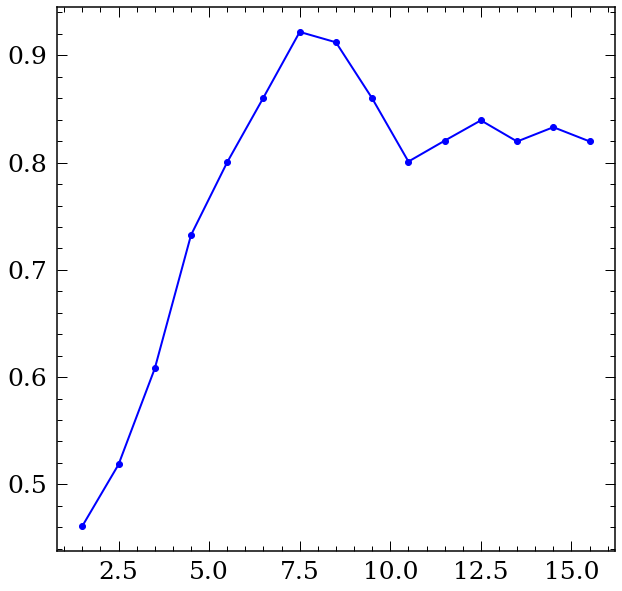

In [624]:
plt.plot(ages, fehscatter_mcmc, 'b-o')

In [625]:
from scipy.interpolate import interp1d

df_slopesave = pd.DataFrame(np.array((ages, fehscatter_mcmc, fehscatter_mcmc_err)).T,
            columns=['age', 'fehscatter', 'fehscatter_err'])
ivanslope = pd.read_csv('rb_slope_etc.csv')
print(ivanslope.columns)
ivanslope_int = interp1d(np.append(ivanslope['t_model'].values, 16),
                        np.append(ivanslope[' slope_old'].values, 
                                  ivanslope[' slope_old'].values[-1]),
                         kind='cubic')
df_slopesave['slopes_rbir'] = ivanslope_int(df_slopesave['age'])
#df_slopesave.to_csv('data_slopps.csv', index=False)

Index(['t_model', ' slope_old', ' slope_new', ' feh_sol_old', ' feh_sol_new',
       ' feh_gc'],
      dtype='object')


Index(['t_model', ' slope_old', ' slope_new', ' feh_sol_old', ' feh_sol_new',
       ' feh_gc'],
      dtype='object')
[1.5 2.5 3.5 4.5 5.5 6.5 7.5]
[4.36539394 0.03733398 1.10890962]


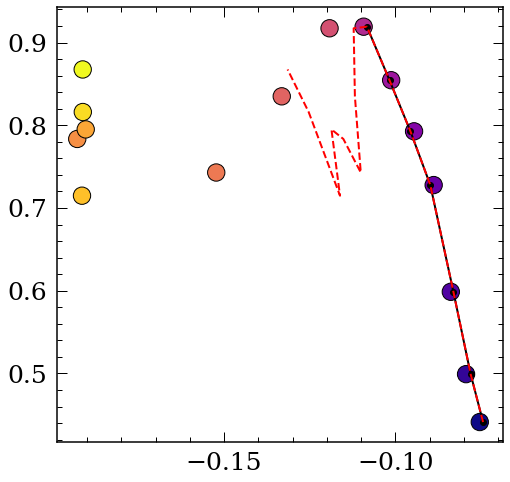

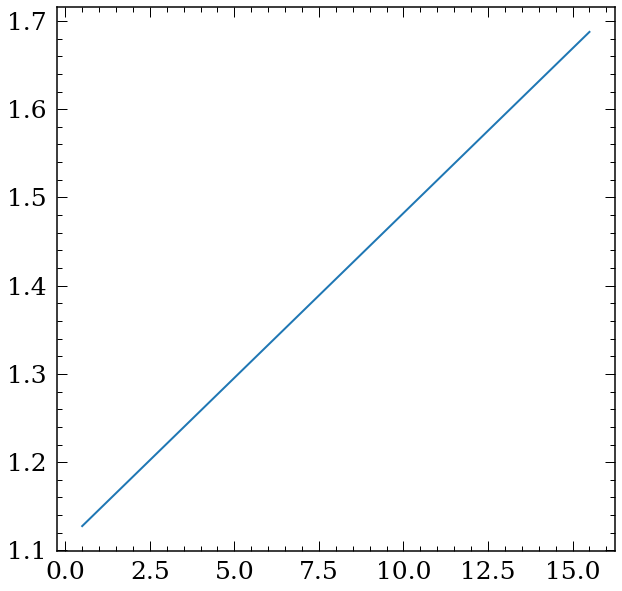

In [663]:
tmax = 12
scaln = 0.04

infslopes = np.zeros(len(ivanslope[' slope_old']))
infslopes = (np.log(tmax-ivanslope['t_model'])*scaln+(-0.07-scaln*np.log(tmax)))
infslopes[ivanslope['t_model']>tmax] = min(infslopes)
ivanslope[' slope_old'] = infslopes


#plt.plot(ivanslope['t_model'], ivanslope[' slope_old'], 'k-')


print(ivanslope.columns)
ivanslope_int = interp1d(np.append(ivanslope['t_model'].values, 16),
                        np.append(ivanslope[' slope_old'].values, 
                                  ivanslope[' slope_old'].values[-1]),
                         kind='cubic')
slopes_rbir = ivanslope_int(ages)

x = slopes_rbir


plt.figure(figsize=(8,8))
plt.scatter(x, fehscatter_range, 
           c=ages, s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df_slopesave)))

indstar = 1
indend = 8

ages_calc = ages[indstar:indend]
print(ages_calc)

def slopecalc(scatter, a, b, c):
    #alpha = abs(alpha)
    a = abs(a)
    #return 1/a*(ages_calc/7)**(-b+c*ages_calc)*scatter-0.07-scatter/a/(7**-b)
    return 1/a/(ages_calc*b+c)*scatter-1/a*scatter/c-0.07

from scipy.optimize import curve_fit
popt_feh, pcov = curve_fit(slopecalc, fehscatter_range[indstar:indend], x[indstar:indend],
                          bounds=([0, 0, -np.inf],[15, 0.5, np.inf]))
plt.plot(slopecalc(fehscatter_range[indstar:indend], *popt_feh), fehscatter_range[indstar:indend],
        "k-o")

def slopecalc(scatter, a, b, c):
    #alpha = abs(alpha)
    a = abs(a)
    ages_calc = ages[indstar:]
    #return 1/a*(ages_calc/7)**(-b+c*ages_calc)*scatter-0.07-scatter/a/(7**-b)
    return 1/a/((ages_calc)*b+c)*scatter-1/a*scatter/c-0.07

plt.plot(slopecalc(fehscatter_range[indstar:], *popt_feh), fehscatter_range[indstar:],
        "r--")
print(popt_feh)


plt.figure()
plt.plot(ages, ((ages)*popt_feh[1]+popt_feh[2]))
#plt.plot(slopecalc(fehscatter_range[1:], 0.39, 0.5), fehscatter_range[1:])

In [664]:
#slopecalc(0, *popt_feh)

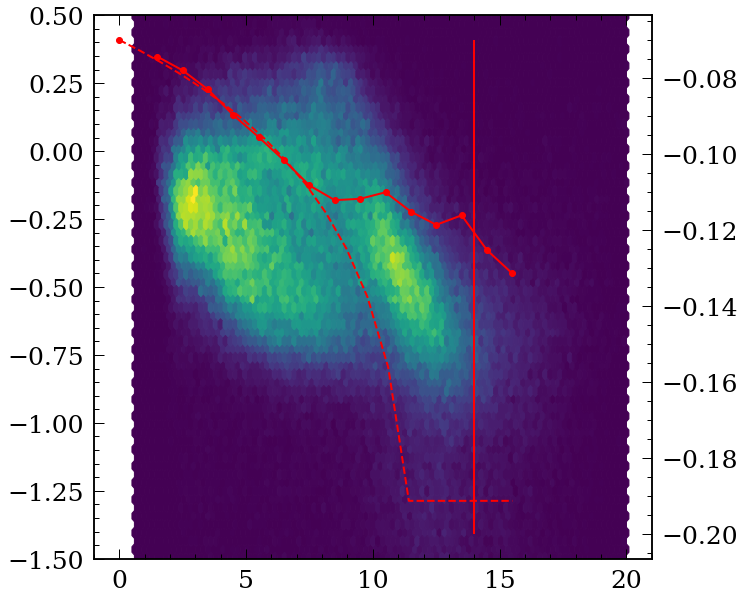

In [665]:
df = df_slopesave
plt.hexbin(sub['AGE'], sub['FEH'])
plt.ylim([-1.5,0.5])
plt.twinx()

def slopecalc(scatter, a, b,c):
    #alpha = abs(alpha)
    a = abs(a)
    ages_calc = ages[1:]
    #return 1/a*(ages_calc/7)**(-b+c*ages_calc)*scatter-0.07-scatter/a/(7**-b)
    return 1/a/(ages_calc*b+c)*scatter-1/a*scatter/c-0.07

plt.plot(ages[1:], slopecalc(fehscatter_range[1:], *popt_feh),'r-o')
df['slope_rbir_infer'] = np.append([-0.07],(slopecalc(fehscatter_range[1:], *popt_feh)))
plt.plot(ivanslope['t_model'], ivanslope[' slope_old'], 'r--')
plt.plot(0,-0.07,'ro')
plt.vlines(14,-0.2,-0.07,color='r')


In [666]:
def getRb(age, feh, func_m, func_b):
    Rb = np.zeros(len(age))
    for i in trange(len(age)):
        m = func_m(age[i])
        b = func_b(age[i])
        #y = m*8.2
        #b = b-y
        
        Rb[i] = (feh[i]-b)/m
    return Rb
        

    

In [667]:
# get Fe/H in solar neiborhood
agebins = np.linspace(0,16,17)
fehave = np.zeros(len(agebins)-1)
fehave_age = np.zeros(len(agebins)-1)
for i in range(len(agebins)-1):
    sub_sing = sub_rbir.loc[(sub_rbir['AGE']>agebins[i])&(sub_rbir['AGE']<agebins[i+1])]
    sub_sing = sub_sing.loc[abs(sub_sing['Rb']-8.2)<0.5]
    fehave[i] = np.median(sub_sing['FEH'].dropna())
fehave_age = (agebins[1:]+agebins[:-1])/2
    
    
fehevl = pd.read_table('feh_t_sol.txt', delim_whitespace=True,
                      names=['0','1'])
fehave_age, fehave = fehevl['0'].values, fehevl['1'].values

fehave = fehave+0.075*8.2

"agebins = np.linspace(0,16,17)\nfehave_age = (agebins[1:]+agebins[:-1])/2\n\n\nplt.figure(figsize=(8,8))\nplt.plot(np.linspace(0,100,100), \n         newfunc(np.linspace(0,100,100)), 'k-')\n\nplt.figure(figsize=(8,8))\nplt.hexbin(sub['AGE'], sub['FEH'], cmap=plt.get_cmap('binary',15), \n           extent=(0,16,-1,0.5), )\n\n#plt.plot(fehave_age, fehave, 'r-o')\n\nplt.plot(fehave_age, newfunc(fehave_age), 'r-o')\n\n\n\nfehave = newfunc(fehave_age)"

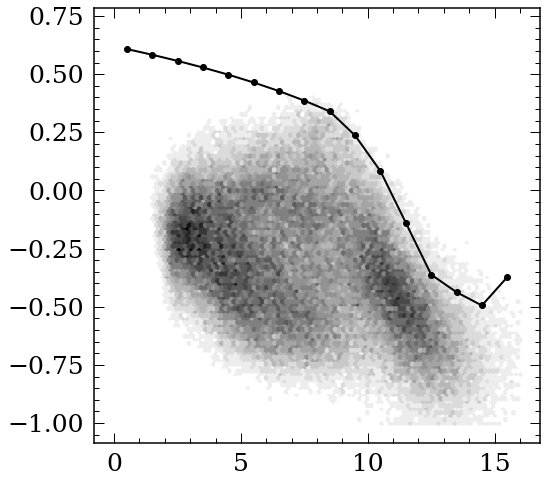

In [668]:
rgcut = 5
#base = 17
base = 15


def newfunc(age):
    return np.log((16-(age)))/np.log(base)-(np.log(16)/np.log(base)-0.72)

# getting moving median for the most metal rich stars
agebins = np.linspace(0,16,17)
avefeh = np.zeros(len(agebins)-1)
for i in range(len(agebins)-1):
    metalrich = sub.loc[(sub['AGE']>agebins[i])&(sub['AGE']<agebins[i+1])]
    metalrich = metalrich.loc[metalrich['R_GUIDING']<rgcut]
    metalrich = metalrich.loc[metalrich['AGE_ERR']<np.diff(agebins)[0]]
    metalrich = metalrich.loc[metalrich['FEH_ERR']<0.03]
    #metalrich = metalrich.loc[metalrich['R']<5]
    #print(len(metalrich))
    if (agebins[i]+agebins[i+1])/2 > 9:
        avefeh[i] = (np.percentile(metalrich['FEH'],99.5))
        #avefeh[i] = (max(metalrich['FEH']))
    else:
        avefeh[i] = newfunc((agebins[i]+agebins[i+1])/2)

    
fehave_age = (agebins[1:]+agebins[:-1])/2
fehave = avefeh-0.1

#fehave[fehave_age==3.5] = fehave[fehave_age==3.5]

fehave[(fehave_age==15.5)] += 0.2


"""ivan = pd.read_csv('rb_slope_etc.csv')
fehave_age = ivan['t_model'].values
fehave = ivan[' feh_gc'].values"""
plt.figure(figsize=(8,8))
plt.plot(fehave_age, fehave, 'k-o', zorder=100)

sub_smallrg = sub.loc[sub['R_GUIDING']<rgcut]
#plt.plot(sub_smallrg['AGE'], sub_smallrg['FEH'],'bo',markersize=1)

#plt.scatter(sub_smallrg['AGE'], sub_smallrg['FEH'],
#           c=sub_smallrg['FEH_ERR'])
#plt.hexbin(sub_smallrg['AGE'], sub_smallrg['FEH'], cmap=plt.get_cmap('binary',15), 
#           extent=(0,16,-1,0.7))


plt.hexbin(sub['AGE'], sub['FEH'], cmap=plt.get_cmap('binary',15), 
           extent=(0,16,-1,0.7))

"""agebins = np.linspace(0,16,17)
avefeh = np.zeros(len(agebins)-1)
for i in range(len(agebins)-1):
    metalrich = sub.loc[(sub['AGE']>agebins[i])&(sub['AGE']<agebins[i+1])]
    #metalrich = metalrich.loc[metalrich['R']<5]
    #print(len(metalrich))
    if (agebins[i]+agebins[i+1])/2 > 0:
        avefeh[i] = np.median(np.percentile(metalrich['FEH'],5))
    else:
        avefeh[i] = newfunc((agebins[i]+agebins[i+1])/2)

    
fehave_age = (agebins[1:]+agebins[:-1])/2
fehave_low = avefeh

plt.plot(fehave_age, fehave, 'r-o')
plt.plot(fehave_age, fehave_low, 'r-o')



plt.xlim([0,16])
plt.ylim([-1,0.7])

plt.twinx()
plt.plot(fehave_age, fehave-fehave_low, 'b-o')"""



"""agebins = np.linspace(0,16,17)
fehave_age = (agebins[1:]+agebins[:-1])/2


plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,100,100), 
         newfunc(np.linspace(0,100,100)), 'k-')

plt.figure(figsize=(8,8))
plt.hexbin(sub['AGE'], sub['FEH'], cmap=plt.get_cmap('binary',15), 
           extent=(0,16,-1,0.5), )

#plt.plot(fehave_age, fehave, 'r-o')

plt.plot(fehave_age, newfunc(fehave_age), 'r-o')



fehave = newfunc(fehave_age)"""

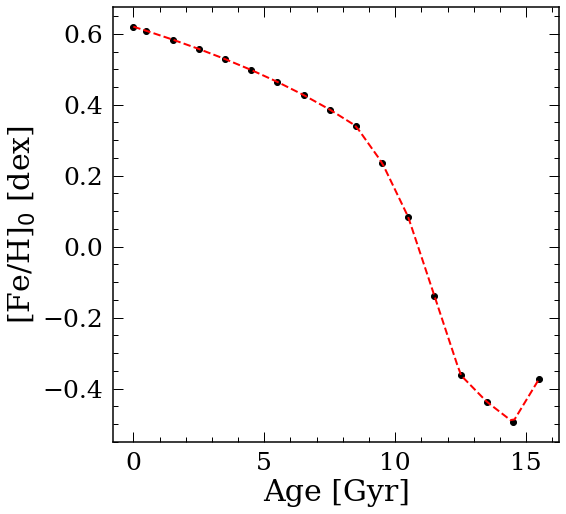

In [669]:

plt.figure(figsize=(8,8))
mfit = (fehave==fehave)
ave_inf = interp1d(np.append([0],fehave_age[mfit]), 
                   np.append([0.62],fehave[mfit]), kind='linear')
fehave = ave_inf(df['age'])
plt.plot(df['age'], fehave, 'ko')
plt.plot(0,0.62,'ko')
plt.plot(np.linspace(0,15.5,100), ave_inf(np.linspace(0,15.5,100)), 'r--')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]$_{0}$ [dex]')
df['feh_cor'] = ave_inf(df['age'])





16
-0.09018420904843183 -0.19656549394130707


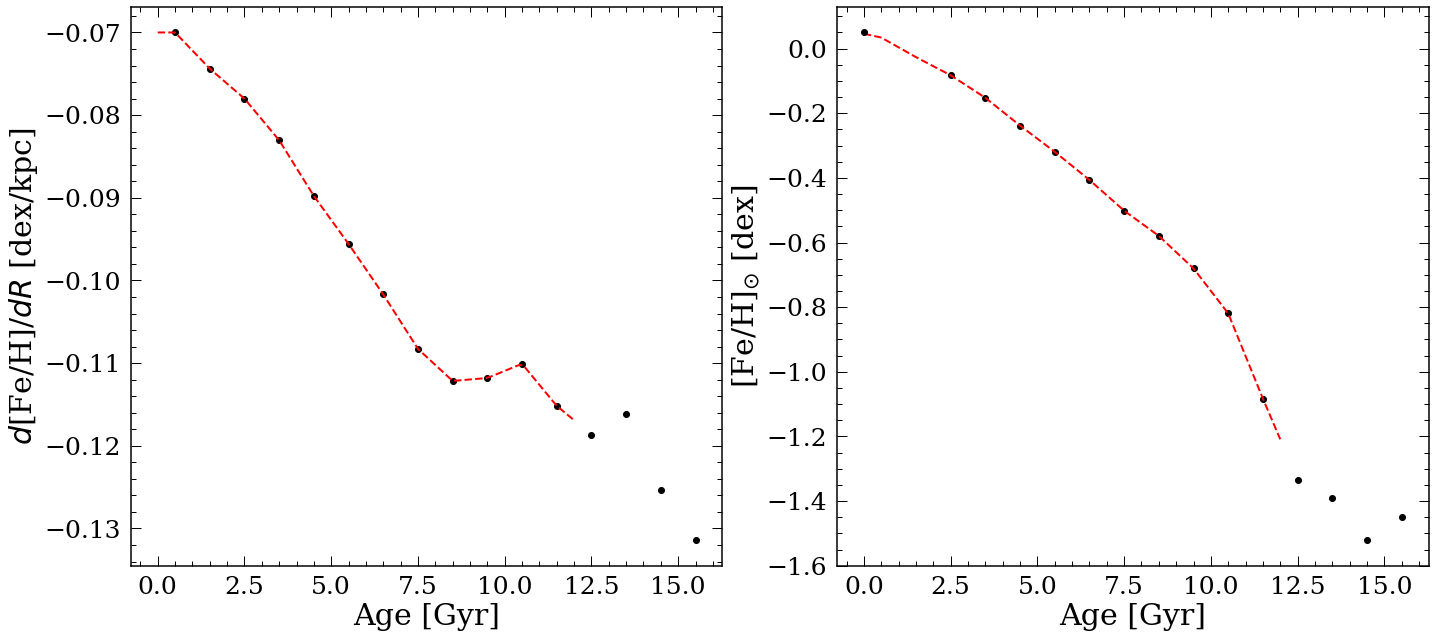

In [670]:
from scipy.interpolate import interp1d

mfit = (df['slope_rbir_infer']==df['slope_rbir_infer'])
print(sum(mfit))

slope_inf = interp1d(np.append([0],df['age'][mfit]), 
                     np.append([-0.07],df['slope_rbir_infer'][mfit]), 
                     kind='linear')


"""ivanslope['slope_cor'] = np.nan
m = (ivanslope['t_model    ']>1.5)
ivanslope['slope_cor'][m] = slope_inf(ivanslope['t_model    '][m])
m2 = (df['age'][mfit]>12)


ivanslope['feh_cor'] = np.nan
m = (ivanslope['t_model    ']>1.5)
ivanslope['feh_cor'][m] = ave_inf(ivanslope['t_model    '][m])
m2 = (df['age'][mfit]>12)
ivanslope_ext = df[mfit][m2][['age', 'slope_rbir_infer','feh_cor']]
ivanslope_ext = ivanslope_ext.rename(columns={'slope_rbir_infer':'slope_cor',
                             'age':'t_model    '})
ivanslope = pd.merge(ivanslope, ivanslope_ext, how='outer')
ivanslope.sort_values('t_model    ').to_csv('rb_slope2.csv', index=False)"""


plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.plot(df['age'][mfit], df['slope_rbir_infer'][mfit], 'ko')
#plt.plot(ivanslope['t_model    '], ivanslope['slope_cor'], 'bo')
plt.plot(np.linspace(0,12,100), slope_inf(np.linspace(0,12,100)), 'r--')
plt.xlabel('Age [Gyr]')
plt.ylabel('$d$[Fe/H]/$dR$ [dex/kpc]')
#plt.vlines(12, ymin=-0.1, ymax=-0.06, color='k')


plt.subplot(1,2,2)
m = (fehave_age>1.5)&(fehave_age<=15.5)
plt.plot(fehave_age[m], slope_inf(fehave_age[m])*8.2+ave_inf(fehave_age[m]), 'ko')
plt.plot(np.linspace(0,12,100), 
         slope_inf(np.linspace(0,12,100))*8.2+ave_inf(np.linspace(0,12,100)), 'r--')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]$_{\odot}$ [dex]')
plt.plot(0,0.1-0.05,'ko')
plt.tight_layout()

print(slope_inf(2.5)*8.3+ave_inf(2.5), np.mean(sub.loc[abs(sub['AGE']-2.5)<0.1]['FEH']))

#pd.DataFrame(np.array((df['age'], fehave, df['slope_rbir_infer'].values)).T,
#            columns=['age','feh_cor','slope_cor']).to_csv('slopes_cor.csv',index=False)



In [671]:
sub_tryRb = sub.loc[(sub['AGE']>0)&(sub['AGE']<15)].reset_index(drop=True)
sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['R']-8.178)<0.5].reset_index(drop=True)
sub_tryRb['Rb_new'] = getRb(sub_tryRb['AGE'].values, sub_tryRb['FEH'].values, slope_inf, ave_inf)



100%|██████████| 89764/89764 [00:02<00:00, 34338.80it/s]


8.456145795246941
0.022882224499799476


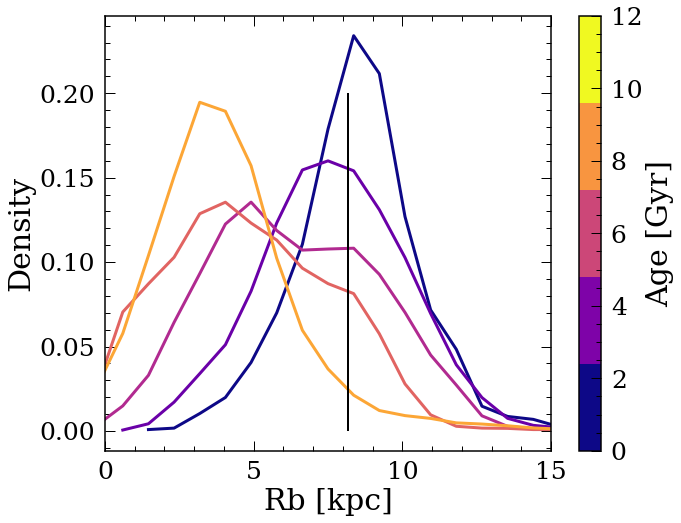

In [672]:
agebin_Rb = np.linspace(0,12,6)
agebin_colors = getcolor(agebin_Rb)
plt.figure(figsize=(10,8))
#plt.hist(sub_tryRb['Rb'], color='k', alpha=0.2, bins=np.linspace(0,20,100))
for i in range(len(agebin_Rb)-1):
    sub_sing = sub_tryRb.loc[(sub_tryRb['AGE']>agebin_Rb[i])&(sub_tryRb['AGE']<agebin_Rb[i+1])]
    fre, edg = np.histogram(sub_sing['Rb_new'], bins=np.linspace(-5,20,30), density=True)
    
    m = (fre!=0)
    plt.plot((edg[1:]+edg[:-1])[m]/2, fre[m], color=agebin_colors[i], linewidth=3)
    if i==0:
        print(np.mean(sub_sing['Rb_new']))
    """plt.vlines(np.mean(sub_sing['Rb_new']), ymin=0, ymax=800, color=agebin_colors[i],
              linewidth=3)"""
#plt.vlines(8.2, ymin=0, ymax=900, color='k')
plt.scatter(100,0,c=5,vmin=min(agebin_Rb),vmax=max(agebin_Rb),
           cmap=plt.get_cmap('plasma', len(agebin_Rb)-1))
plt.xlim([0,15])
plt.xlabel('Rb [kpc]')
plt.ylabel('Density')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.vlines(8.178,0,0.2, color='k')
print(sum(sub_tryRb['Rb_new']<0)/len(sub_tryRb['Rb_new']))



In [673]:
sub_tryRb = sub.loc[(sub['AGE']>0)&(sub['AGE']<=15)].reset_index(drop=True)
sub_tryRb['Rb_new'] = getRb(sub_tryRb['AGE'].values, sub_tryRb['FEH'].values, slope_inf, ave_inf)




100%|██████████| 240266/240266 [00:07<00:00, 32037.97it/s]


1.9703179233951869
2.4050677380997882
2.705029693239744
2.8951445753406926
2.894238449080172
2.5917858742495063
2.057213842455501
0.024970143919384225


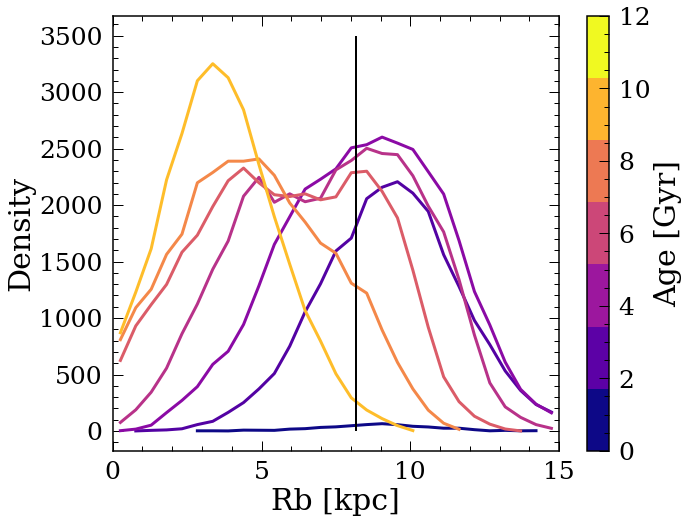

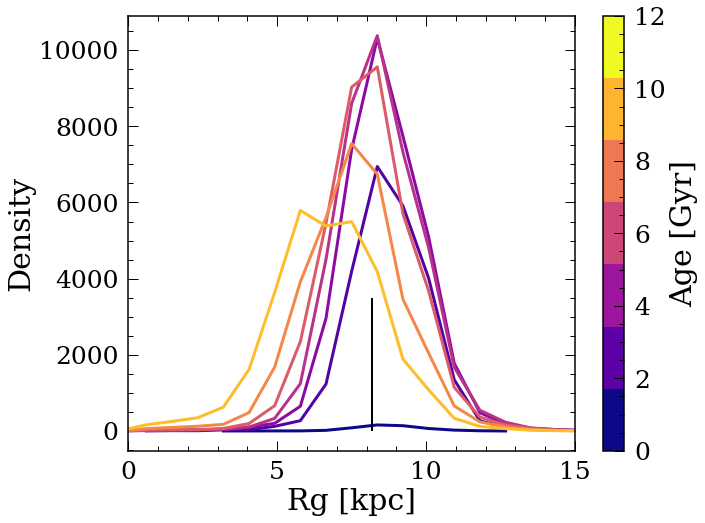

In [675]:
agebin_Rb = np.linspace(0,12,8)
agebin_colors = getcolor(agebin_Rb)
plt.figure(figsize=(10,8))
sub_tryRb = sub_tryRb.loc[sub_tryRb['FEH']>-1]
#plt.hist(sub_tryRb['Rb'], color='k', alpha=0.2, bins=np.linspace(0,20,100))
for i in range(len(agebin_Rb)-1):
    sub_sing = sub_tryRb.loc[(sub_tryRb['AGE']>agebin_Rb[i])&(sub_tryRb['AGE']<agebin_Rb[i+1])]
    fre, edg = np.histogram(sub_sing['Rb_new'], bins=np.linspace(0,15,30), density=False)
    
    m = (fre!=0)
    plt.plot((edg[1:]+edg[:-1])[m]/2, fre[m], color=agebin_colors[i], linewidth=3)
    
    print(np.std(sub_sing['Rb_new']))
    """plt.vlines(np.mean(sub_sing['Rb_new']), ymin=0, ymax=800, color=agebin_colors[i],
              linewidth=3)"""
#plt.vlines(8.2, ymin=0, ymax=900, color='k')
plt.scatter(100,0,c=5,vmin=min(agebin_Rb),vmax=max(agebin_Rb),
           cmap=plt.get_cmap('plasma', len(agebin_Rb)-1))
plt.vlines(8.178,0,3500, color='k')
plt.xlim([0,15])
plt.xlabel('Rb [kpc]')
plt.ylabel('Density')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')


plt.figure(figsize=(10,8))
for i in range(len(agebin_Rb)-1):
    sub_sing = sub_tryRb.loc[(sub_tryRb['AGE']>agebin_Rb[i])&(sub_tryRb['AGE']<agebin_Rb[i+1])]
    fre, edg = np.histogram(sub_sing['R_GUIDING'], bins=np.linspace(-5,20,30), density=False)
    
    m = (fre!=0)
    plt.plot((edg[1:]+edg[:-1])[m]/2, fre[m], color=agebin_colors[i], linewidth=3)
    
    """plt.vlines(np.mean(sub_sing['Rb_new']), ymin=0, ymax=800, color=agebin_colors[i],
              linewidth=3)"""
#plt.vlines(8.2, ymin=0, ymax=900, color='k')
plt.scatter(100,0,c=5,vmin=min(agebin_Rb),vmax=max(agebin_Rb),
           cmap=plt.get_cmap('plasma', len(agebin_Rb)-1))
plt.vlines(8.178,0,3500, color='k')
plt.xlim([0,15])
plt.xlabel('Rg [kpc]')
plt.ylabel('Density')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')


print(sum(sub_tryRb['Rb_new']<0)/len(sub_tryRb['Rb_new']))




In [676]:
sub_tryRb['Rb'] = sub_tryRb['Rb_new']
#sub_tryRb.to_pickle('NewRb.pkl')
#sub_tryRb.to_pickle('NewRb_dip.pkl')

In [677]:
def monoage_line_alpha(feh,r,age,agebin=np.linspace(0,14,8),
                feherr=[],xlims=[0,25],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    

    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        xlims = [np.mean(r_sing)-np.std(r_sing), np.mean(r_sing)+np.std(r_sing)]
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()

    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter



0.0707952082157135
6.539166756769634 3.3536328010074437


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


"\nages_afe, fehscatter_afe, fehscatter_afe_err = monoage_line_range_mc(sub_check['ALPHA_H'].values, \n                                        sub_check['R_GUIDING'].values, \n                                        sub_check['AGE'].values,\n                                        sub_check['ALPHA_H_ERR'].values, \n                                        sub_check['R_err'].values, \n                                        sub_check['AGE_ERR'].values,\n                                        agebin=agebincalc,\n                                        xlims=[0,15],mcmc=100)"

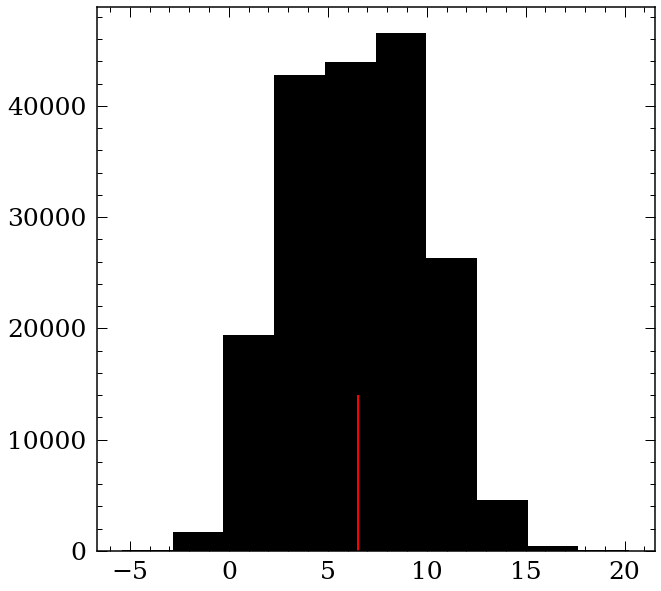

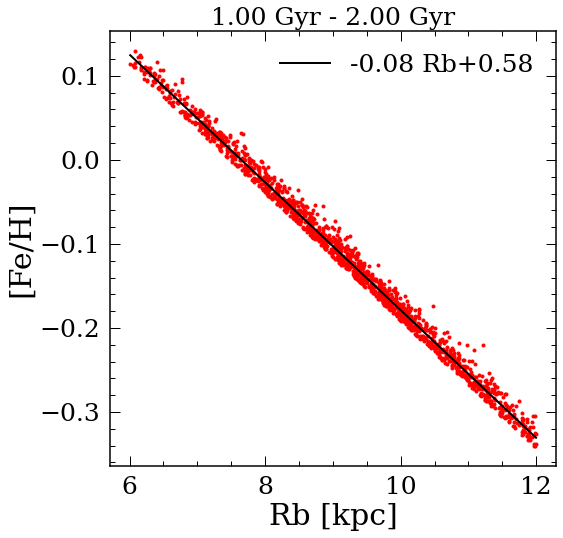

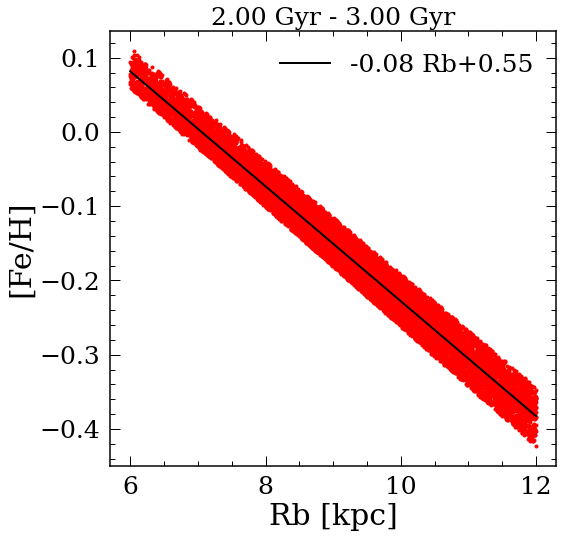

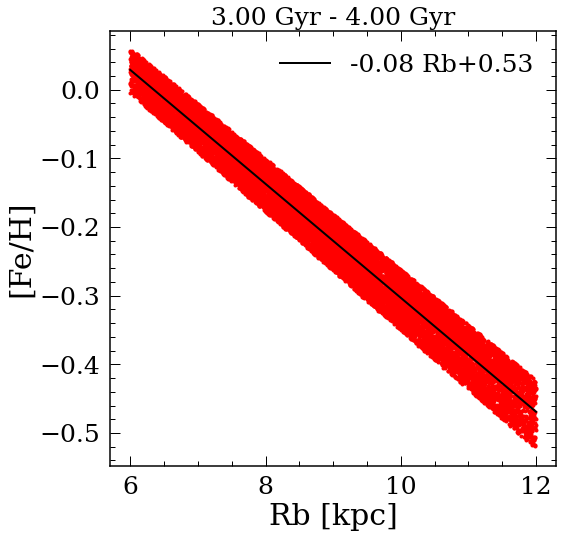

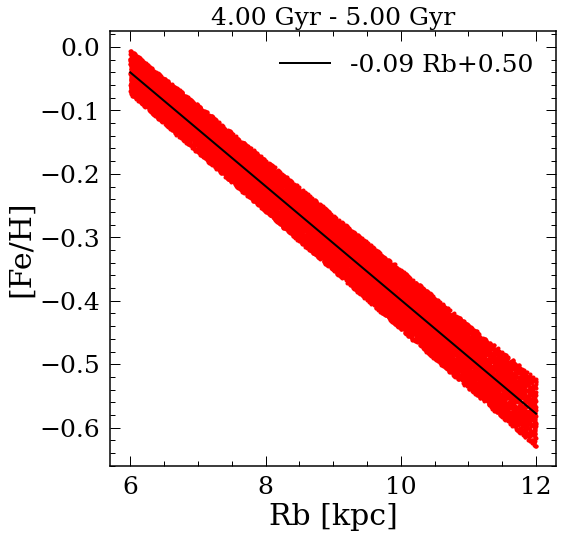

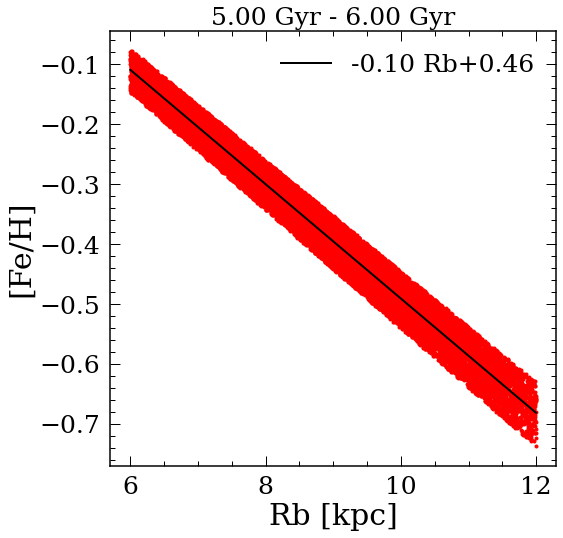

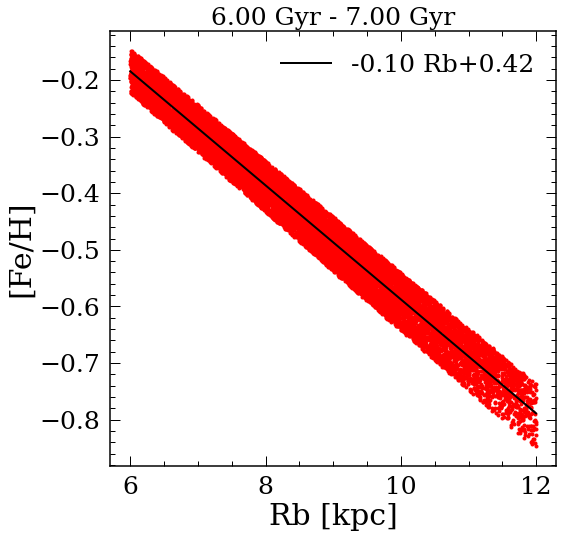

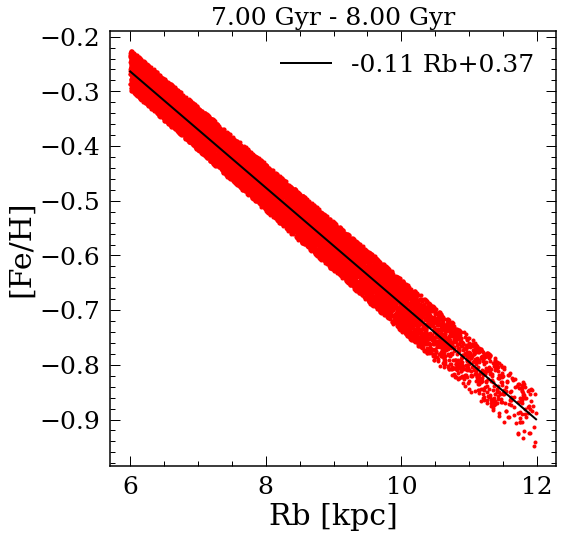

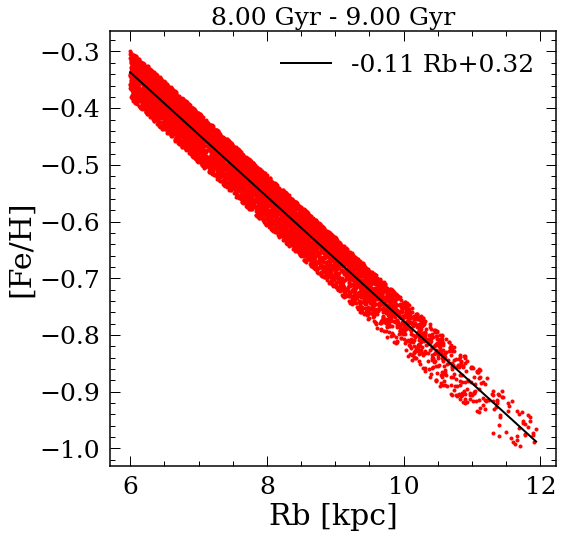

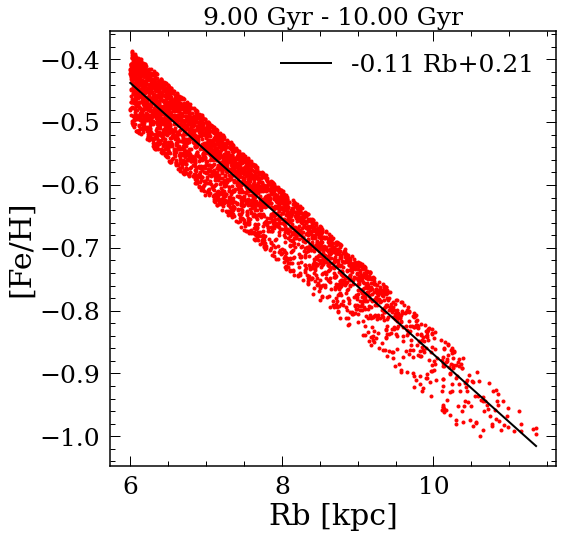

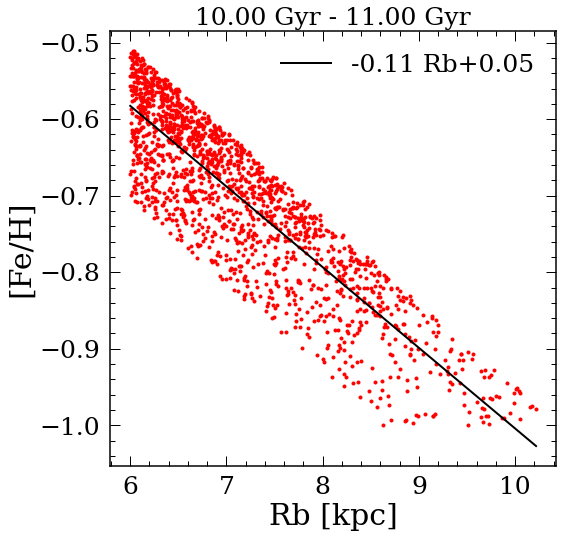

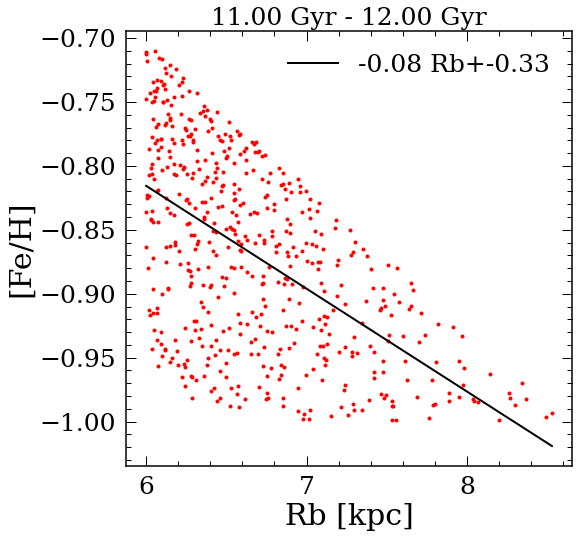

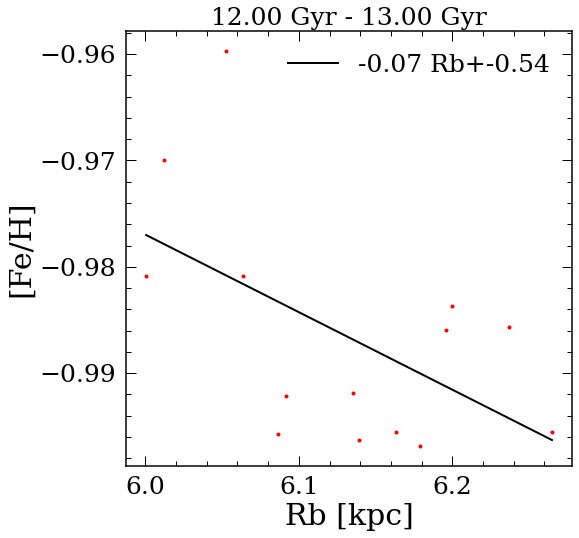

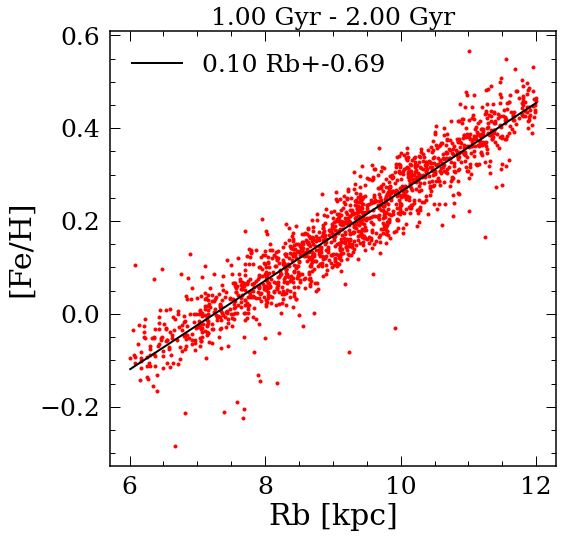

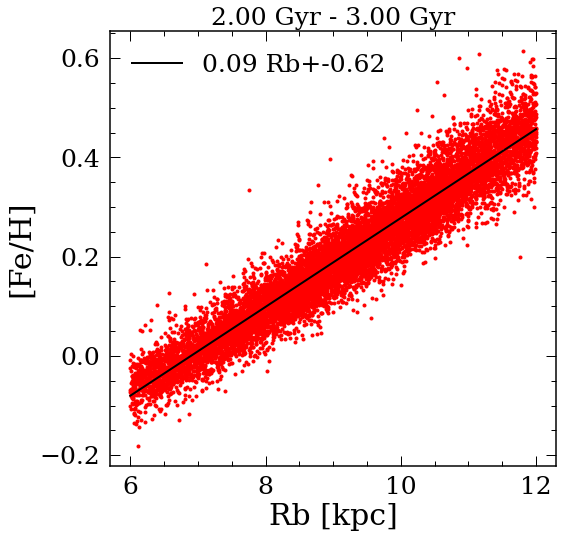

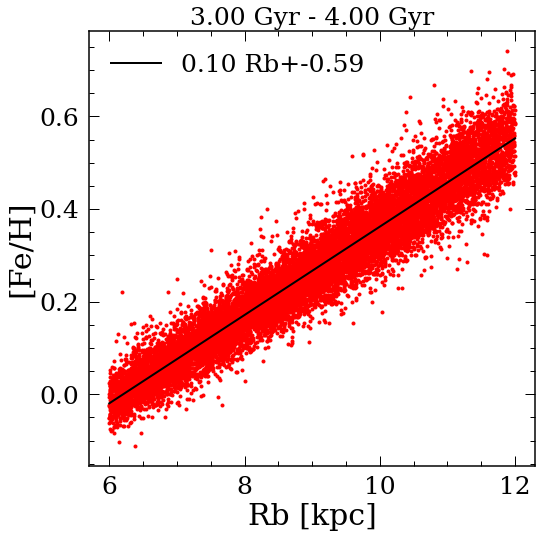

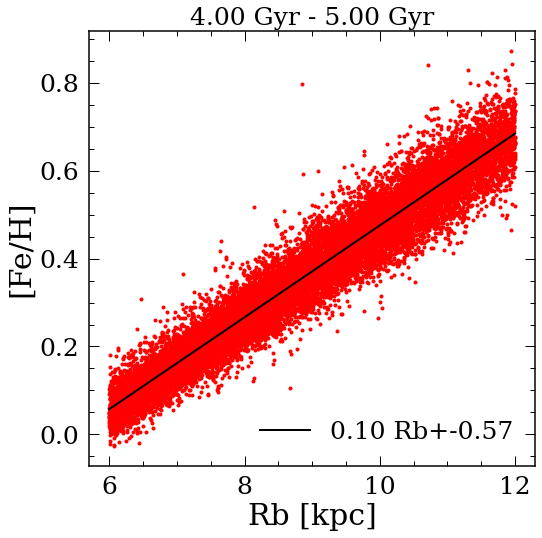

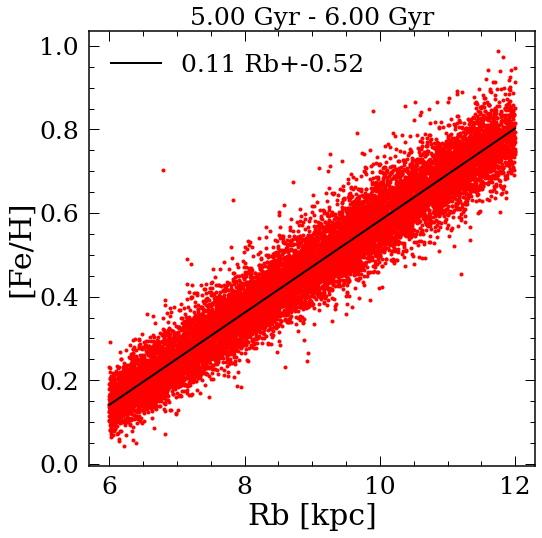

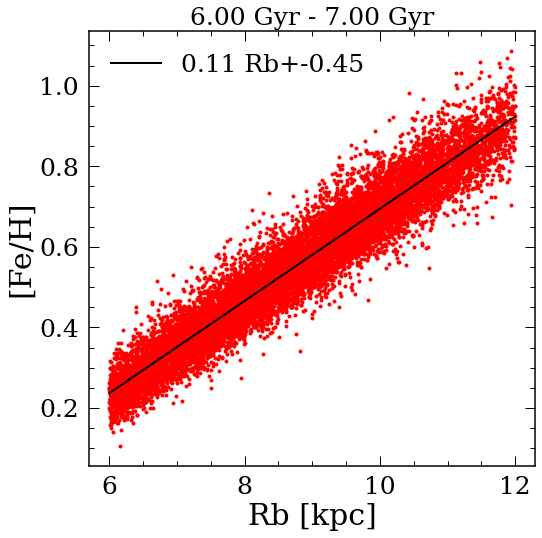

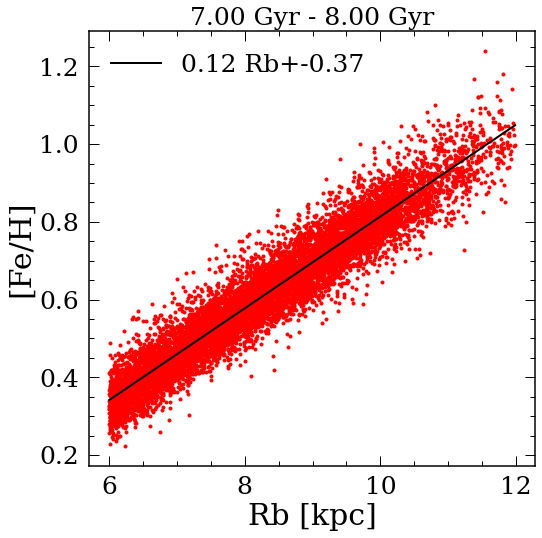

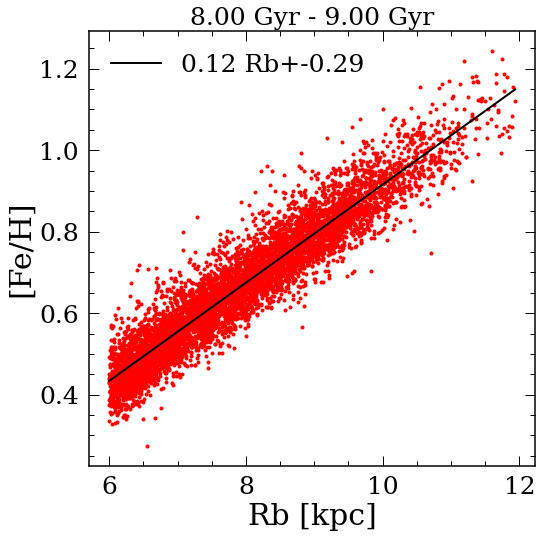

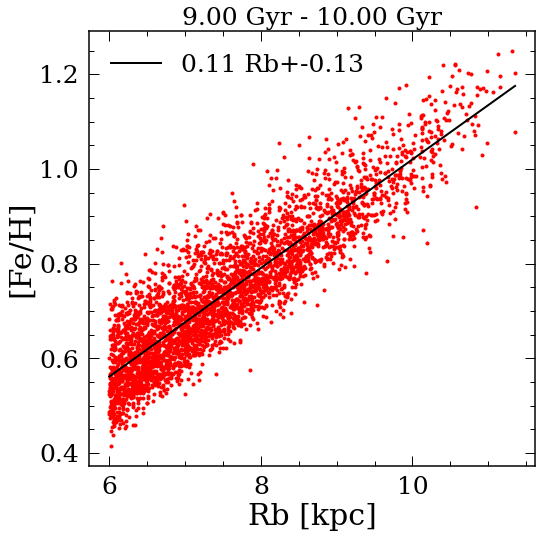

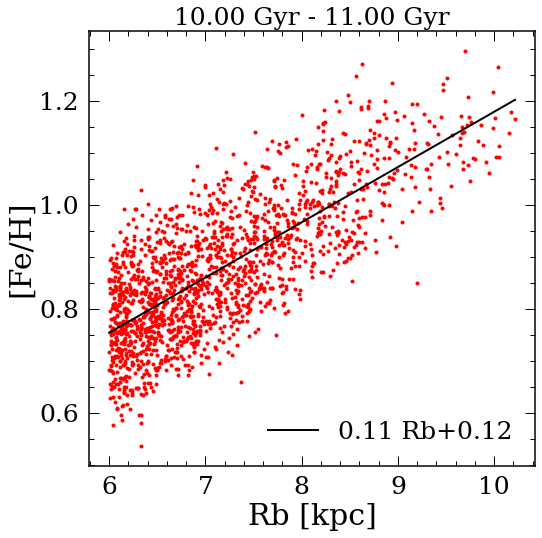

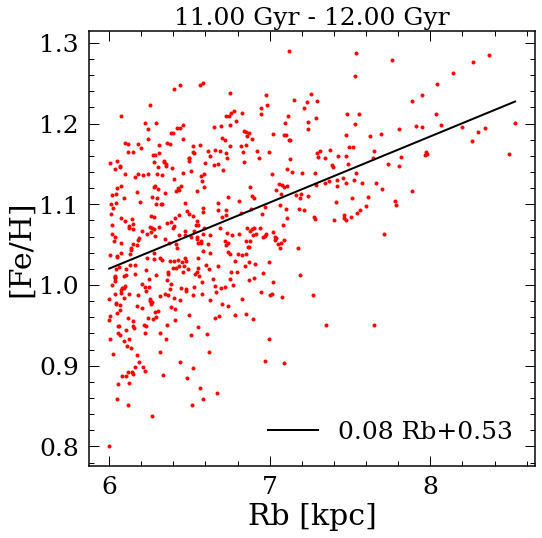

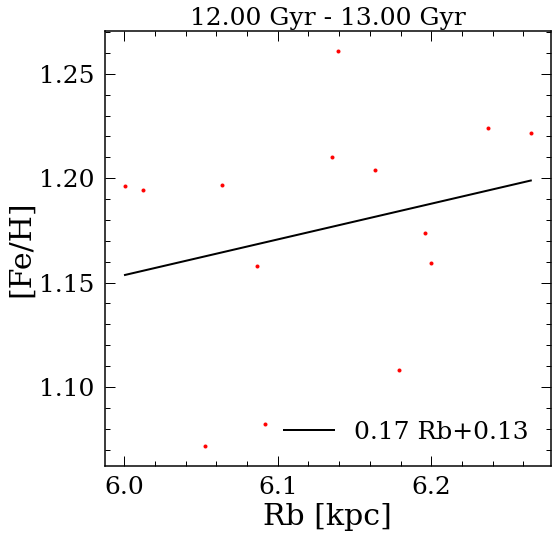

In [681]:
#sub_tryRb['Rb'] = sub_tryRb['Rb_new']

from scipy.interpolate import interp1d
agefit = 15
sub_tryRb = sub_tryRb.dropna(subset=['Rb','AGE','ALPHA_FE'])
sub_tryRb_sel = sub_tryRb.loc[sub_tryRb['AGE_ERR']<np.diff(agebincalc)[0]]
sub_tryRb_sel = sub_tryRb_sel.loc[sub_tryRb_sel['ALPHA_FE_ERR']<0.1]
sub_tryRb_sel = sub_tryRb_sel.loc[sub_tryRb_sel['FEH']>-1]
sub_tryRb_sel['ALPHA_H'] = sub_tryRb_sel['ALPHA_FE']-sub_tryRb_sel['FEH']
sub_tryRb_sel['ALPHA_H_ERR'] = np.sqrt(sub_tryRb_sel['FEH_ERR']**2+sub_tryRb_sel['ALPHA_FE_ERR']**2)

def hilow_disk(feh, alpha):
    hi_low = np.zeros(len(feh))
    
    m = feh<0.2
    hi_low[m] = alpha[m]>0.12
    
    p = fitpoints([0.2,0.5], [0.12,0.1])
    hi_low[~m] = alpha[~m]>p(feh[~m])
    
    return hi_low

#sub_tryRb_sel['hi_low'] = hilow_disk(sub_tryRb_sel['feh'].values, sub_tryRb_sel['ofe'].values)


#sub_tryRb_sel = sub_tryRb_sel.loc[sub_tryRb_sel['hi_low'] == 0]
print(np.mean(sub_tryRb_sel['ALPHA_H_ERR']))
#sub_tryRb_sel = sub_tryRb_sel.loc[abs(sub_tryRb_sel['Z'])<0.5]

#df = pd.read_csv('Xiang_selslope_afe.csv')
ages_afe, slopes_afe, fehscatter_afe = monoage_line_range(sub_tryRb_sel['ALPHA_H'].values, 
                                        sub_tryRb_sel['R_GUIDING'].values, 
                                        sub_tryRb_sel['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=[7,10],
                                       plotlegend=False,pltfig=False)


plt.hist(sub_tryRb_sel['Rb'].values, color='k')
plt.vlines(np.median(sub_tryRb_sel['Rb'].values), ymin=0, ymax=14000, color='r')
print(np.median(sub_tryRb_sel['Rb'].values), np.std(sub_tryRb_sel['Rb'].values))

medrb = np.median(sub_tryRb_sel['Rb'].values)
stdrb = np.std(sub_tryRb_sel['Rb'].values)

#xlims = [medrb-stdrb,medrb+stdrb]
xlims = [6,12]
ages_afe, slopesafe_rbir, fehscatterrb_afe = monoage_line(sub_tryRb_sel['FEH'].values, 
                                        sub_tryRb_sel['Rb'].values, 
                                        sub_tryRb_sel['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=xlims)



#sub_tryRb = sub_rbir.dropna(subset=['Rb','AGE','ALPHA_FE'])
#sub_tryRb_sel = sub_rbir.loc[sub_rbir['AGE_ERR']<np.diff(agebincalc)[0]]
#sub_tryRb_sel = sub_tryRb_sel.loc[sub_tryRb_sel['ALPHA_FE_ERR']<0.1]
#sub_tryRb_sel = sub_tryRb_sel.loc[sub_tryRb_sel['FEH']>-1]
ages_afe, slopesafe_rbir, fehscatterrb_afe = monoage_line(sub_tryRb_sel['ALPHA_H'].values, 
                                        sub_tryRb_sel['Rb'].values, 
                                        sub_tryRb_sel['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=xlims)

sub_check['ALPHA_H'] = sub_check['ALPHA_FE']-sub_check['FEH']
sub_check['ALPHA_H_ERR'] = np.sqrt(sub_check['FEH_ERR']**2+sub_check['ALPHA_FE_ERR']**2)

sub_check = sub_check.dropna(subset=['ALPHA_H', 'ALPHA_H_ERR'])
sub_check = sub_check.loc[abs(sub_check['Z'])<1]
sub_check = sub_check.loc[sub_check['ECC']<0.5]
sub_check = sub_check.loc[sub_check['FEH']>-1]
sub_check = sub_check.loc[sub_check['ALPHA_H_ERR']<0.05]

"""
ages_afe, fehscatter_afe, fehscatter_afe_err = monoage_line_range_mc(sub_check['ALPHA_H'].values, 
                                        sub_check['R_GUIDING'].values, 
                                        sub_check['AGE'].values,
                                        sub_check['ALPHA_H_ERR'].values, 
                                        sub_check['R_err'].values, 
                                        sub_check['AGE_ERR'].values,
                                        agebin=agebincalc,
                                        xlims=[0,15],mcmc=100)"""



In [682]:
ages_afe, fehscatter_afe, fehscatter_afe_err = np.array(ages_afe), np.array(fehscatter_afe), np.array(fehscatter_afe_err)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[-0.05356802  2.23564019]


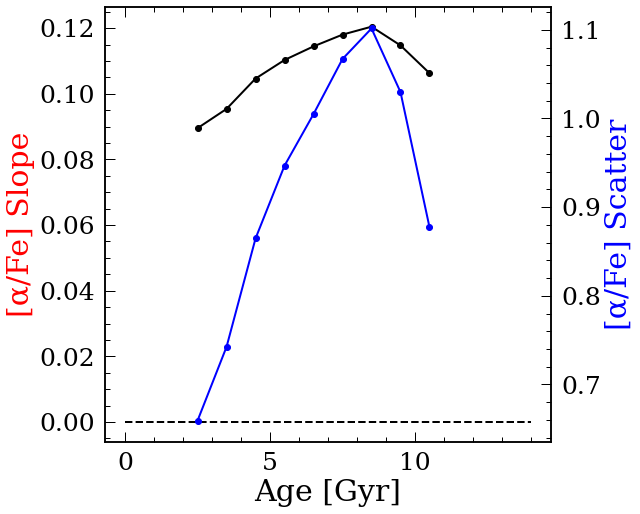

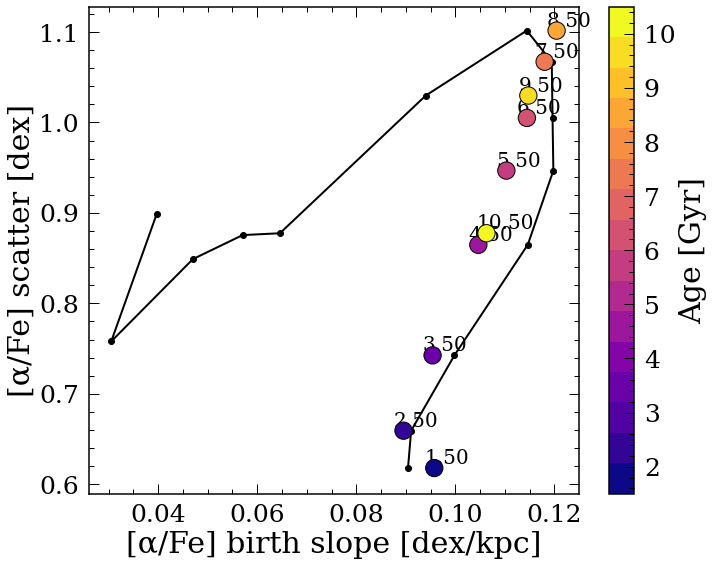

In [683]:
plt.figure(figsize=(8,8))
maxageshow=11
#plt.errorbar(ages_afe, slopes_afe, fmt='r--o')
m2 = (ages_afe>2)&(ages_afe<maxageshow)

plt.plot(ages_afe[m2], slopesafe_rbir[m2], 'k-o',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
#plt.ylim([-0.15, 0.05])

plt.twinx()
#plt.errorbar(ages_afe, fehscatter_afe, yerr=fehscatterafe_err, fmt='b-o')
plt.errorbar(ages_afe[m2], fehscatter_afe[m2], yerr=fehscatter_afe_err[m2], fmt='b-o')
#plt.ylim([0.,0.1])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)


df_afe = pd.DataFrame(np.array((ages_afe, slopes_afe, fehscatter_afe, slopesafe_rbir,
                               fehscatterrb_afe)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir','fehscatter_rbir'])


df_afe = df_afe.dropna(subset=['slopes','fehscatter']).reset_index(drop=True)

df_afe['slopes_rbir'] = df_afe['slopes_rbir']
m2 = (ages>0)&(ages<maxageshow)

slopesafe_rbir, fehscatter_afe, fehscatter_afe_err = np.array(slopesafe_rbir,dtype=float), np.array(fehscatter_afe,dtype=float), np.array(fehscatter_afe_err,dtype=float)

plt.figure(figsize=(10,8))
plt.scatter(slopesafe_rbir[m2], fehscatter_afe[m2], 
           c=ages[m2], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)),zorder=10)
plt.errorbar(slopesafe_rbir[m2], fehscatter_afe[m2], 
             yerr=fehscatter_afe_err[m2], fmt='ko',zorder=-1)

#p = fitpoints(fehscatter_afe[m2], slopesafe_rbir[m2])
plt.xlabel('[α/Fe] birth slope [dex/kpc]')
plt.ylabel('[α/Fe] scatter [dex]')
#plt.plot(p(fehscatter_afe)[m2],
#         (fehscatter_afe)[m2], 'r-', 
#         label="%.2f$Δm$+%.2f"%(p[1],p[0]))

n = ages[m2]
for i, txt in enumerate(n):
    plt.annotate('%.2f'%txt, (slopesafe_rbir[m2][i]-0.002, fehscatter_afe[m2][i]+0.005), 
                 fontsize=20,color='k')
plt.tight_layout()

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()

from scipy import stats
m3 = (ages[m2]<12)
#print(stats.pearsonr(fehscatter_afe[m2][m3], slopesafe_rbir[m2][m3]))

df_afe = pd.DataFrame(np.array((ages_afe, fehscatter_afe, fehscatter_afe_err,
                                      slopesafe_rbir)).T,
            columns=['age', 'fehscatter', 'fehscatter_err','slopes_rbir'])
#df_afe.to_csv('data_slopps_afe.csv', index=False)



indstar = 1
indend = 10

print(ages[indstar:indend])

a, b, c = popt_feh

ages_calc = ages[indstar:indend]
def slopecalc(scatter, d, e):
    #alpha = abs(alpha)
    a, b, c = popt_feh
    #b = 0.1
    a = abs(a)
    b = abs(b)
    #return 1/a*(ages_calc/7)**(-b+c*ages_calc)*scatter-0.07-scatter/a/(7**-b)+d
    return e/a/(ages_calc*b+c)*scatter-1/a*scatter/c+d

from scipy.optimize import curve_fit
popt, pcov = curve_fit(slopecalc, fehscatter_afe[indstar:indend], slopesafe_rbir[indstar:indend])


def slopecalc(scatter, d, e):
    #alpha = abs(alpha)
    a, b, c = popt_feh
    #b = 0.1
    a = abs(a)
    b = abs(b)
    ages_calc = ages[indstar:]
    #return 1/a*(ages_calc/7)**(-b+c*ages_calc)*scatter-0.07-scatter/a/(7**-b)+d
    return e/a/(ages_calc*b+c)*scatter-1/a*scatter/c+d

plt.plot(slopecalc(fehscatter_afe[indstar:], *popt), fehscatter_afe[indstar:],
        "k-o")
print(popt)


100%|██████████| 19/19 [00:00<00:00, 107.22it/s]


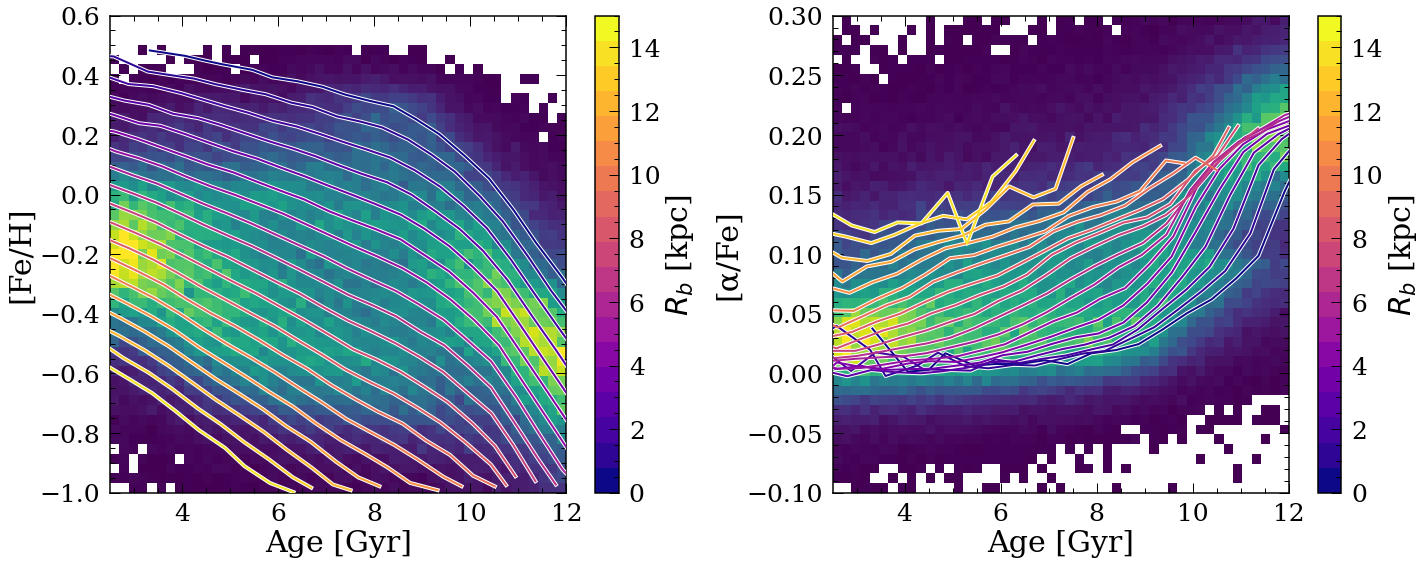

In [652]:
def coldensity(x,y,binsize=50,extend=[]):
    if len(extend)==0:
        extend=(min(x),max(x),min(y),max(y))
    H, yedges, xedges = np.histogram2d(x, y, 
                                bins=(np.linspace(extend[0],extend[1],binsize),
                                        np.linspace(extend[2],extend[3],binsize)))
    for i in trange(len(yedges)-1):
        m = (x>yedges[i])&(x<yedges[i+1])
        H[i,:] = H[i,:]/sum(m)

    for i in range(len(H[0,:])):
        for j in range(len(H[:,0])):
            if H[j,i] == 0:
                H[j,i] = np.nan

    return yedges, xedges, H.T



sub_tryRb = sub_tryRb.dropna(subset=['ALPHA_FE'])

Rbbin = np.linspace(0,15,20)
color_amr = getcolor(range(len(Rbbin)))

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

yedges, xedges, H = coldensity(sub_tryRb['AGE'], sub_tryRb['FEH'],binsize=50,
          extend=(2.5,12,-1,0.6))

plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=0.07)


sub_tryRb = sub_tryRb.sort_values(by='AGE')
age_rbnow, feh_rbnow = movingMed_time(sub_tryRb['AGE'], sub_tryRb['FEH'],
                                     1,1)
           
#plt.plot(age_rbnow, feh_rbnow, 'r-')

for i in trange(len(Rbbin)-1):
    m = (sub_tryRb['Rb']>Rbbin[i])&(sub_tryRb['Rb']<Rbbin[i+1])
    age_amr_all, feh_amr_all = sub_tryRb['AGE'].values[m], sub_tryRb['FEH'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     1,0.5)
    plt.plot(age_amr, feh_amr, '-', color=color_amr[i], linewidth=2,zorder=10)
    plt.plot(age_amr, feh_amr, '-', color='w', linewidth=4,zorder=9)
    plt.xlim([2.5,12])
    plt.ylim([-1,0.6])
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('$R_b$ [kpc]')


plt.subplot(1,2,2)

yedges, xedges, H = coldensity(sub_tryRb['AGE'], sub_tryRb['ALPHA_FE'],binsize=50,
          extend=(2.5,12,-0.1,0.3))

plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=0.09)


for i in trange(len(Rbbin)-1):
    m = (sub_tryRb['Rb']>Rbbin[i])&(sub_tryRb['Rb']<Rbbin[i+1])
    age_amr_all, feh_amr_all = sub_tryRb['AGE'].values[m], sub_tryRb['ALPHA_FE'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     1,0.5)
    #feh_amr = gaussian_filter(feh_amr, 0.5)
    plt.plot(age_amr, feh_amr, '-', color=color_amr[i], linewidth=2,zorder=10)
    plt.plot(age_amr, feh_amr, '-', color='w', linewidth=4,zorder=9)
    plt.xlim([2.5,12])
    plt.ylim([-0.1,0.3])
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('$R_b$ [kpc]')
plt.tight_layout()

#plt.savefig('Figures/eps/afe_evol',bbox_inches='tight')
#plt.savefig('Figures/afe_evol.png',bbox_inches='tight')




100%|██████████| 14/14 [00:14<00:00,  1.03s/it]


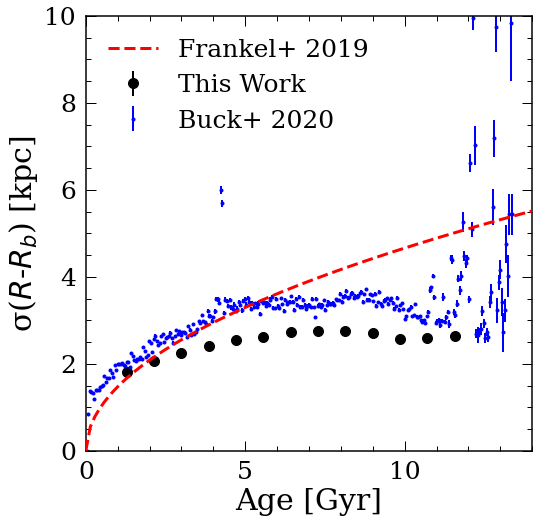

In [653]:
from astropy import units as u
from astropy import uncertainty as unc



sub_tryRb['R_err'] = (sub_tryRb['PARALLAX'])**-2*(sub_tryRb['PARALLAX_ERROR'])


agebincalc_rm = np.linspace(0,12,15)
mean_dr = np.zeros(len(agebincalc_rm)-1)
mean_dr_err = np.zeros(len(agebincalc_rm)-1)

sub_tryRb['AGE_sca'] = sub_tryRb['AGE']
sub_tryRb = sub_tryRb.loc[sub_tryRb['AGE_ERR']<np.diff(agebincalc_rm)[0]]
sub_tryRb_sub = sub_tryRb
sub_tryRb_sub = sub_tryRb.loc[abs(sub_tryRb['R_GUIDING'])<20]
sub_tryRb_sub = sub_tryRb_sub.loc[sub_tryRb_sub['Rb']<20]
sub_tryRb_sub = sub_tryRb_sub.loc[sub_tryRb_sub['FEH']>-1]

for i in trange(len(agebincalc_rm)-1):
    sub_tryRb_sing = sub_tryRb_sub.loc[(sub_tryRb_sub['AGE_sca']>agebincalc_rm[i])&(sub_tryRb_sub['AGE_sca']<agebincalc_rm[i+1])]
    #mean_dr[i] = np.std(sub_tryRb_sing['Rb_new']-sub_tryRb_sing['R'])    
    #mean_dr_err[i] = mean_dr[i]/(len(sub_tryRb_sing)-1)
    
    sub_tryRb_sing = sub_tryRb_sing.dropna(subset=['Rb','R_err','R_GUIDING'])
    sub_tryRb_sing = sub_tryRb_sing.loc[sub_tryRb_sing['R_err']<1]
    
    if len(sub_tryRb_sing)<30:
        mean_dr[i] = np.nan
        mean_dr_err[i] = np.nan
        continue
        
    Rbdist = unc.normal(sub_tryRb_sing['Rb'].values, 
                     std=sub_tryRb_sing['R_err'].values, 
                     n_samples=1000)
    Rdist = unc.normal(sub_tryRb_sing['R_GUIDING'].values, 
                     std=sub_tryRb_sing['R_err'].values, 
                     n_samples=1000)
    
    drdist = np.std(Rbdist-Rdist)
    
    mean_dr[i] = drdist.pdf_median()
    mean_dr_err[i] = np.median(np.sqrt(drdist.pdf_var()))
    
    
plt.figure(figsize=(8,8))
dR_sim = pd.read_pickle('BuckMigration.pkl')

plt.errorbar((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_dr,
             yerr=mean_dr_err, fmt='ko', label='This Work', 
            markersize=10)
plt.plot(np.linspace(0,14,100), 
         3.9*np.sqrt(np.linspace(0,14,100)/7), 
         'r--', label='Frankel+ 2019', zorder=10,
        linewidth=3)

m = (dR_sim['NoS']>30)
plt.errorbar(dR_sim['meanage'][m], dR_sim['meandR'][m],
             yerr=dR_sim['meadR_err'][m], fmt='bo', 
             label='Buck+ 2020', markersize=3)

plt.xlim([0,14])
plt.ylim([0,10])
plt.xlabel('Age [Gyr]')
plt.ylabel('σ($R$-$R_b$) [kpc]')
plt.legend()

#plt.savefig('Figures/eps/migrationStr',bbox_inches='tight')
#plt.savefig('Figures/migrationStr.png',bbox_inches='tight')

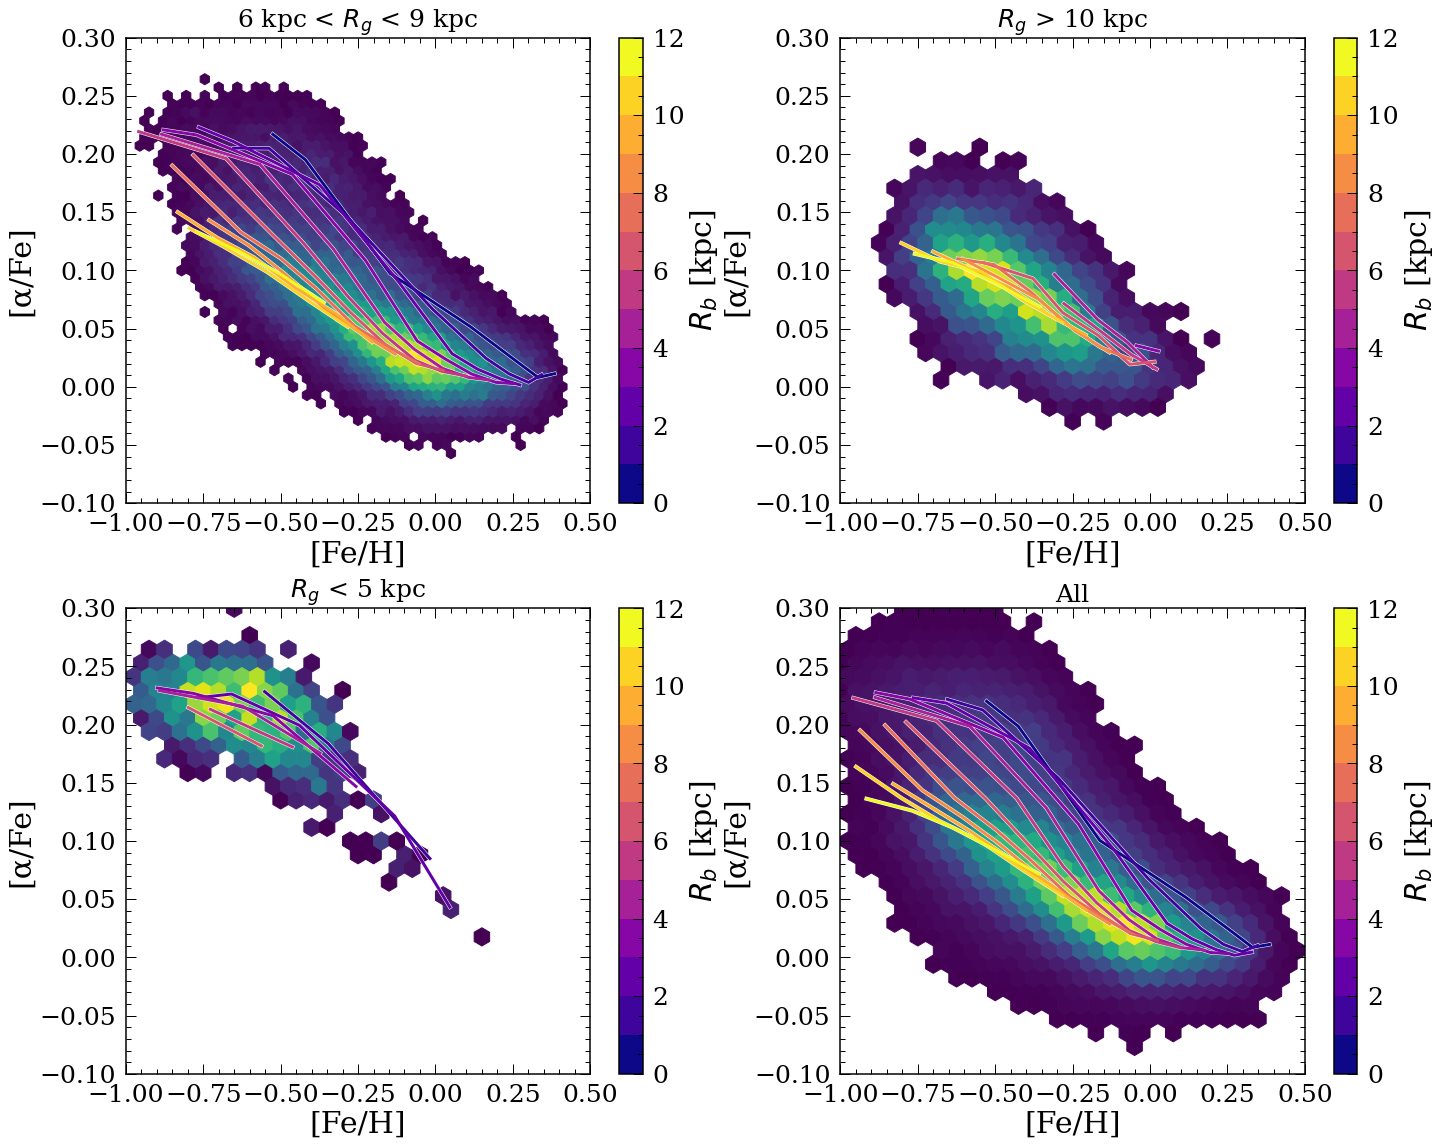

In [654]:
import warnings
warnings.filterwarnings('ignore')
def drawArrow(A, B, colors):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=0.01, head_length=0.03, 
              length_includes_head = True,
              color=colors)
    
agebin = np.linspace(2,15,10)
Rbbin = np.linspace(0,12,13)

colors = getcolor(range(len(Rbbin)-1))

sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R_GUIDING']-7.5)<1.5].reset_index(drop=True)

plt.figure(figsize=(20,16))
plt.subplot(2,2,1)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], 
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=10)

meanfeh = np.zeros((len(agebin)-1,len(Rbbin)-1))
meanafe = np.zeros((len(agebin)-1,len(Rbbin)-1))

for j in range(len(Rbbin)-1):
    for i in range(len(agebin)-1):
        m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
        m = m&(sub_tryRb_sn['Rb']>Rbbin[j])
        m = m&(sub_tryRb_sn['Rb']<Rbbin[j+1])
        if sum(m)<50:
            meanfeh[i,j] = np.nan
            meanafe[i,j] = np.nan
        else:
            meanfeh[i,j] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
            meanafe[i,j] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())
    plt.plot(meanfeh[:,j], meanafe[:,j], '-', color=colors[j], linewidth=3,
            zorder=10)
    plt.plot(meanfeh[:,j], meanafe[:,j], '-', color='w', linewidth=4,
            zorder=9)
    """plt.scatter(meanfeh[:,j], meanafe[:,j], c = colors[j], 
                s=80, edgecolor='w',
                cmap=plt.get_cmap('plasma', len(Rbbin)-1),
               vmin=Rbbin[0], vmax=Rbbin[-1],zorder=9)"""
    
#for i in range(len(agebin)-1):
#    plt.plot(meanfeh[i,:], meanafe[i,:], '--', color='w',zorder=4)



plt.scatter(-100, -100, c = 10, 
            s=80, cmap=plt.get_cmap('plasma', len(Rbbin)-1),
           vmin=Rbbin[0], vmax=Rbbin[-1])

plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('$R_b$ [kpc]')
plt.xlim([-1,0.5])
plt.ylim([-0.1,0.3])
plt.title('6 kpc < $R_g$ < 9 kpc', fontsize=25)
#plt.title('7.7 kpc < Rb_corrected < 8.7 kpc', fontsize=25)





sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R_GUIDING'])>10].reset_index(drop=True)

plt.subplot(2,2,2)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], 
          extent=(-1,0.5,-0.1,0.3), gridsize=30, mincnt=10)

meanfeh = np.zeros((len(agebin)-1,len(Rbbin)-1))
meanafe = np.zeros((len(agebin)-1,len(Rbbin)-1))

for j in range(len(Rbbin)-1):
    for i in range(len(agebin)-1):
        m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
        m = m&(sub_tryRb_sn['Rb']>Rbbin[j])
        m = m&(sub_tryRb_sn['Rb']<Rbbin[j+1])
        if sum(m)<50:
            meanfeh[i,j] = np.nan
            meanafe[i,j] = np.nan
        else:
            meanfeh[i,j] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
            meanafe[i,j] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())
    plt.plot(meanfeh[:,j], meanafe[:,j], '-', color=colors[j], linewidth=3,
            zorder=10)
    plt.plot(meanfeh[:,j], meanafe[:,j], '-', color='w', linewidth=4,
            zorder=9)
    """plt.scatter(meanfeh[:,j], meanafe[:,j], c = colors[j], 
                s=80, edgecolor='w',
                cmap=plt.get_cmap('plasma', len(Rbbin)-1),
               vmin=Rbbin[0], vmax=Rbbin[-1],zorder=9)"""
    
#for i in range(len(agebin)-1):
#    plt.plot(meanfeh[i,:], meanafe[i,:], '--', color='w',zorder=4)




plt.scatter(-100, -100, c = 10, 
            s=80, cmap=plt.get_cmap('plasma', len(Rbbin)-1),
           vmin=Rbbin[0], vmax=Rbbin[-1])

plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('$R_b$ [kpc]')
plt.xlim([-1,0.5])
plt.ylim([-0.1,0.3])
plt.title('$R_g$ > 10 kpc', fontsize=25)






sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R_GUIDING'])<5].reset_index(drop=True)

plt.subplot(2,2,3)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], 
          extent=(-1,0.5,-0.1,0.3), gridsize=30, mincnt=10)

meanfeh = np.zeros((len(agebin)-1,len(Rbbin)-1))
meanafe = np.zeros((len(agebin)-1,len(Rbbin)-1))

for j in range(len(Rbbin)-1):
    for i in range(len(agebin)-1):
        m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
        m = m&(sub_tryRb_sn['Rb']>Rbbin[j])
        m = m&(sub_tryRb_sn['Rb']<Rbbin[j+1])
        if sum(m)<50:
            meanfeh[i,j] = np.nan
            meanafe[i,j] = np.nan
        else:
            meanfeh[i,j] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
            meanafe[i,j] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())
    plt.plot(meanfeh[:,j], meanafe[:,j], '-', color=colors[j], linewidth=3,
            zorder=10)
    plt.plot(meanfeh[:,j], meanafe[:,j], '-', color='w', linewidth=4,
            zorder=9)
    """plt.scatter(meanfeh[:,j], meanafe[:,j], c = colors[j], 
                s=80, edgecolor='w',
                cmap=plt.get_cmap('plasma', len(Rbbin)-1),
               vmin=Rbbin[0], vmax=Rbbin[-1],zorder=9)"""
    
#for i in range(len(agebin)-1):
#    plt.plot(meanfeh[i,:], meanafe[i,:], '--', color='w',zorder=4)




plt.scatter(-100, -100, c = 10, 
            s=80, cmap=plt.get_cmap('plasma', len(Rbbin)-1),
           vmin=Rbbin[0], vmax=Rbbin[-1],zorder=1)

plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('$R_b$ [kpc]')
plt.xlim([-1,0.5])
plt.ylim([-0.1,0.3])
plt.title('$R_g$ < 5 kpc', fontsize=25)







#Rbbin = np.linspace(0,15,16)

plt.subplot(2,2,4)
plt.hexbin(sub_tryRb['FEH'], sub_tryRb['ALPHA_FE'], 
          extent=(-1,0.5,-0.1,0.3), gridsize=30, mincnt=10)

meanfeh = np.zeros((len(agebin)-1,len(Rbbin)-1))
meanafe = np.zeros((len(agebin)-1,len(Rbbin)-1))

for j in range(len(Rbbin)-1):
    for i in range(len(agebin)-1):
        m = (sub_tryRb['AGE']>agebin[i])&(sub_tryRb['AGE']<agebin[i+1])
        m = m&(sub_tryRb['Rb']>Rbbin[j])
        m = m&(sub_tryRb['Rb']<Rbbin[j+1])
        if sum(m)<50:
            meanfeh[i,j] = np.nan
            meanafe[i,j] = np.nan
        else:
            meanfeh[i,j] = np.median(pd.Series(sub_tryRb['FEH'].values[m]).dropna())
            meanafe[i,j] = np.median(pd.Series(sub_tryRb['ALPHA_FE'].values[m]).dropna())
    plt.plot(meanfeh[:,j], meanafe[:,j], '-', color=colors[j], linewidth=3,
            zorder=10)
    plt.plot(meanfeh[:,j], meanafe[:,j], '-', color='w', linewidth=4,
            zorder=9)
    """plt.scatter(meanfeh[:,j], meanafe[:,j], c = colors[j], 
                s=80, edgecolor='w',
                cmap=plt.get_cmap('plasma', len(Rbbin)-1),
               vmin=Rbbin[0], vmax=Rbbin[-1],zorder=9)"""
    
#for i in range(len(agebin)-1):
#    plt.plot(meanfeh[i,:], meanafe[i,:], '--', color='w',zorder=4)




plt.scatter(-100, -100, c = 10, 
            s=80, cmap=plt.get_cmap('plasma', len(Rbbin)-1),
           vmin=Rbbin[0], vmax=Rbbin[-1])

plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('$R_b$ [kpc]')
plt.xlim([-1,0.5])
plt.ylim([-0.1,0.3])
plt.title('All', fontsize=25)

plt.tight_layout()


